Code for **"Change Detection"** reproducing results for OSCD dataset. 
We recommend to have a 48Gb GPU to test full image at once.

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

# Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np

#Importing different models
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip

import torch
import torch.optim
import random
#random.seed(42)
from utils.common_utils import *
from utils.cd_utils import *
from utils.encoder_features import VGG_Net, Encoder_Net
from torchvision import transforms as F
from utils.data_transforms import ColorJitter

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import cohen_kappa_score


from utils.loss import info_loss, feature_InfoNce_loss, cm_InfoNce_loss

torch.backends.cudnn.enabled   = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64
print('ok')

ok


# Select testing image here (Default: lasvegas in OSCD)

In [11]:
# Testing image number in OSCD dataset.
IMAGE_N    = 7 #Beirut(22), Lasvegas(7), cupertino(18)

# Testing image list in OSCD dataset.
IMAGE_LIST = ['brasilia','montpellier','norcia','rio','saclay_w','valencia','dubai','lasvegas','milano','chongqing', 'aguasclaras','bercy','bordeaux','nantes','paris','rennes','saclay_e','abudhabi','cupertino','pisa','beihai','hongkong','beirut','mumbai']

# Set path for pre-change, post-change images.
# CM is used only to calculate the final metrics. We dont use it for training.
img1_path    = '/home/mariapap/Music/METRIC_unsupervised_test/'
img2_path    = '/home/mariapap/Music/METRIC_unsupervised_test/'
cm_path      = '/home/mariapap/Music/METRIC_unsupervised_test/'

print("Change detection on |>>>>> " + IMAGE_LIST[IMAGE_N] + " <<<<<| in OSCD dataset")

Change detection on |>>>>> lasvegas <<<<<| in OSCD dataset


# Loading pre-change and post-change images

In [12]:
# Notation
# img1 = pre-change image
# img2 = post-change image

img1, img2 = get_onera_RGBimg(img1_path, img2_path)

# Printing shape of the original MSI images
# bands, W, H = img2.shape

# Loading groud-truth change map (only used to calculate performace metrics)

In [13]:
# Notation: cm = binary change map
cm = get_onera_cm(cm_path) 
if cm.ndim == 3:
    cm = cm[:, :, 1]

# If you dont have enough GPU to run the demo: try it on a smaller patch

In [6]:
#If you dont have enough GPU to experiment on full image, test it on a small patch
#Uncomment the following lines if you want to run it on a small patch

#crop_size = 256

#img1 = img1[:, 0:crop_size, 0:crop_size]
#img2 = img2[:, 0:crop_size, 0:crop_size]
#cm   = cm[0:crop_size, 0:crop_size]

# Testing with a artificial change

In [7]:
# You can add artificial change and test our algorithm is able to detect that change
#img2[:, 50:70, 50:70] = 1
#cm[50:70, 50:70] = np.amax(cm)

# Visualizing pre-change, post-change, and ground-truth change mask

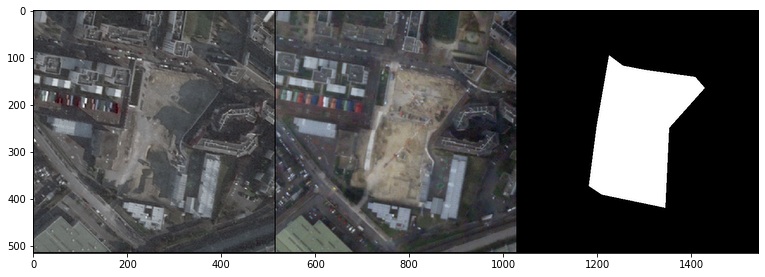

  |----------- T1 --------------|------------ T2 ------------|----- Change Map ----------|


In [14]:
img1_rgb = (img1-np.amin(img1))/(np.amax(img1)-np.amin(img1))
img2_rgb = (img2-np.amin(img2))/(np.amax(img2)-np.amin(img2))
cm       = cm/np.amax(cm)

plot_image_grid([img1_rgb, img2_rgb, np.expand_dims(cm, axis=0)], factor = 10, nrow = 3);
print("  |----------- T1 --------------|------------ T2 ------------|----- Change Map ----------|")

# PCC: Polynomial Color Correction

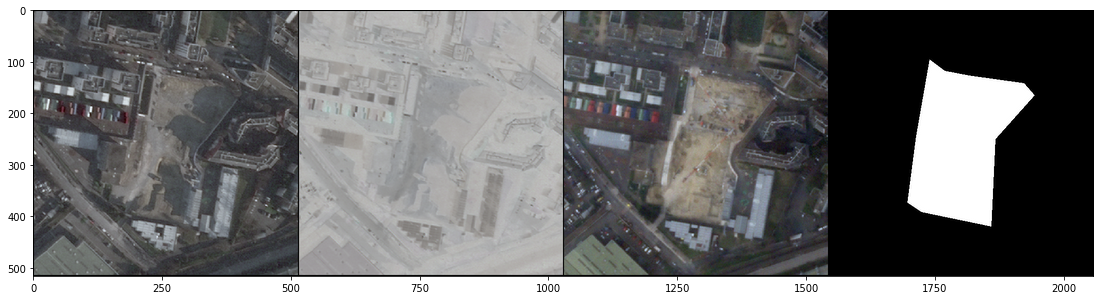

   |----------- T1 ------------|--- T1 (Color Balanced) ---|----------- T2 -----------|----------- cm --------|


In [9]:
# Import polynomial matching functions
from color_balancing.utils import get_mapping_func, apply_mapping_func

# Get color mapping function
m_t      = get_mapping_func(img1, img2)
img1_cb  = apply_mapping_func(img1, m_t)

# Get RGB image
img1_rgb    = (img1-np.amin(img1))/(np.amax(img1)-np.amin(img1))
img1_cb_rgb = (img1_cb-np.amin(img1_cb))/(np.amax(img1_cb)-np.amin(img1_cb))
img2_rgb    = (img2-np.amin(img2))/(np.amax(img2)-np.amin(img2))

plot_image_grid([img1_rgb, img1_cb_rgb, img2_rgb, np.expand_dims(cm, axis=0)], factor = 15, nrow =4);
print("   |----------- T1 ------------|--- T1 (Color Balanced) ---|----------- T2 -----------|----------- cm --------|")

# Replace img1 with color balanced verison of img1
img1 = img1_cb
img1_rgb = img1_cb_rgb

# Converting img1, and img2 to torch tensors and get augmented images

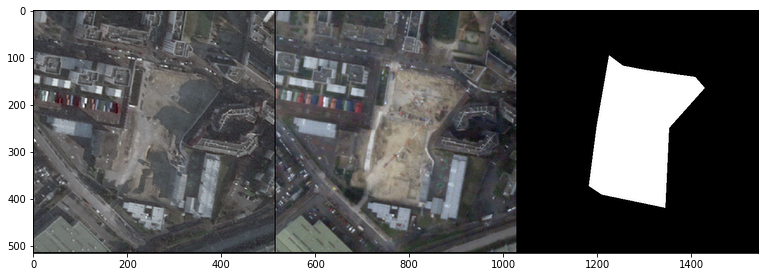

  |--------- T1(aug) ------------|---------- T2(aug) ----------|----- Change Map ----------|


In [21]:
# Converting numpy arrays to pytorch tensors
img1_var = np_to_torch(img1).type(dtype).cpu()
img2_var = np_to_torch(img2).type(dtype).cpu()
mask_var = np_to_torch(cm).type(dtype).cpu()

#----- Color Jittering parameters -----#
color_adjust_para = [0.2, 0.2, 0.2, 0.2]

#Img1 and Img2 color jittering
Img1_Jitter = ColorJitter(color_adjust_para)
Img2_Jitter = ColorJitter(color_adjust_para)

img1_j      = Img1_Jitter(img1_var.cpu())[0]
img2_j      = Img2_Jitter(img2_var.cpu())[0]

#----- Visualizing Color Jittered Example Image -----#
img1j_rgb = (img1_j-np.amin(img1_j))/(np.amax(img1_j)-np.amin(img1_j))
img2j_rgb = (img2_j-np.amin(img2_j))/(np.amax(img2_j)-np.amin(img2_j))
cm        = cm/np.amax(cm)

plot_image_grid([img1j_rgb, img2j_rgb, np.expand_dims(cm, axis=0)], factor = 10, nrow = 3);
print("  |--------- T1(aug) ------------|---------- T2(aug) ----------|----- Change Map ----------|")

# Setup Change Probability Genetator(D-CPG) and its input (difference image)

In [22]:
# General parameters
pad           = 'reflection' # 'zero'
OPT_OVER      = 'net'
OPTIMIZER     = 'adam'
net_input     = torch.abs(img1_var-img2_var)
input_depth   = 3
show_every    = 5
figsize       = 12
reg_noise_std = 0.03

# Parameters of Deep Change Dector
LR               = 0.0001
reg_noise_std    = 0.03
num_iter         = 50
threshold        = 0.7
N_vgg            = 3
requires__grad   = True

distance_measure  = torch.nn.L1Loss()
distance_measure2 = torch.nn.L1Loss()
InfoNCE_loss      = info_loss(temp_c = 1, temp_nc = 1)

# Define change prediction network
net = ResNet(input_depth, 2, 32, 32, need_sigmoid=True, act_fun='LeakyReLU')

#Experimenting with other network architectures
#net = skip(input_depth, 2, 
           #num_channels_down = [128] * 5,
           #num_channels_up =   [128] * 5,
           #num_channels_skip =    [128] * 5,  
           #filter_size_up = 3, filter_size_down = 3, 
           #upsample_mode='nearest', filter_skip_size=1,
           #need_softmax=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
         
net = net.type(dtype)

Encoder= VGG_Net(resize=False, requires__grad=requires__grad) #.cuda()

#Experimenting with different transfer learning methods.
#Encoder           = Encoder_Net().cuda()
#pretrained_dict   = torch.load("/media/lidan/ssd/Chaminda/change_detection/pretrain_encoder/outputs/best_model.pth")
#Encoder_dict      = Encoder.state_dict()
#pretrained_dict   = {k: v for k, v in pretrained_dict.items() if k in Encoder_dict}
#Encoder_dict.update(pretrained_dict) 
#Encoder.load_state_dict(Encoder_dict)

Encoder.eval()
for param in Encoder.parameters():
    param.requires_grad = requires__grad


#Printing number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

FileNotFoundError: [Errno 2] No such file or directory: '/media/lidan/ssd/Chaminda/change_detection/VGG_finetune_AID/saved_model/vgg16_AID_049fc.pth'

# Visualizing feature representations from encoder of img1 and img2

In [17]:
img1_feat = Encoder(np_to_torch(img1).type(dtype))
img2_feat = Encoder(np_to_torch(img2).type(dtype))

#Visualizing VGG features...
feat1 = np.expand_dims(torch_to_np(img1_feat[1][0, 20, :, :].unsqueeze(0)), 0)
feat2 = np.expand_dims(torch_to_np(img2_feat[1][0, 20, :, :].unsqueeze(0)), 0)
plot_image_grid([feat1, feat2], factor=figsize, nrow=2);

NameError: name 'Encoder' is not defined

# Test-Time Training (TTT) Loop

Starting optimization with ADAM


/home/lidan/anaconda3/envs/CCT/lib/python3.9/site-packages/torch/nn/functional.py:3502: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


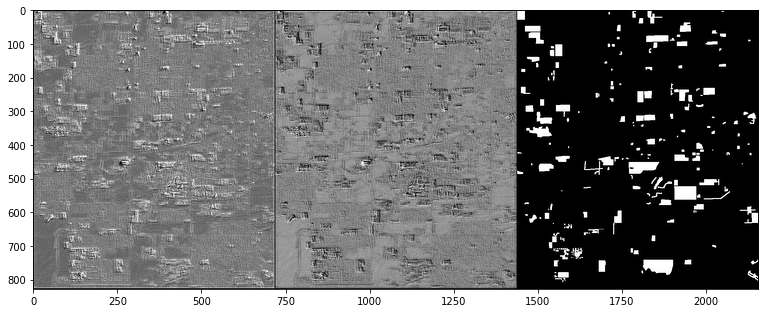

Precision: 0.351  Recall: 0.320    F1-Score: 0.335     AUC: 0.622


/home/lidan/anaconda3/envs/CCT/lib/python3.9/site-packages/torch/nn/functional.py:3502: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


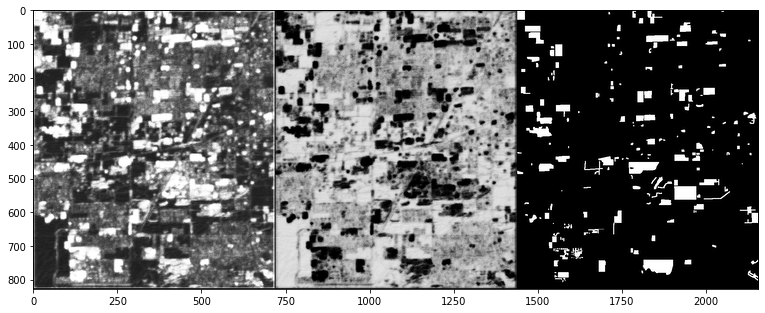

Precision: 0.373  Recall: 0.924    F1-Score: 0.531     AUC: 0.959


/home/lidan/anaconda3/envs/CCT/lib/python3.9/site-packages/torch/nn/functional.py:3502: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


KeyboardInterrupt: 

In [13]:
i           = 0
AUC_best    = 0.0
change_best = np.empty(cm.shape)
def closure():
    
    global i
    global AUC_best
    global change_best
    
    net_input = net_input_saved
    
    # Getting change and unchange map
    out = net(net_input)
    
    # Change probability (Pc) and unchanged probability (Pc') map
    pred_cm   = out[0, 0, :, :]
    pred_ncm  = 1.0 - pred_cm
    
    # Image features
    img1_feat = Encoder(np_to_torch(img1).type(dtype))
    img2_feat = Encoder(np_to_torch(img2).type(dtype))
    
    # -------- pixel to pixel loss function -------#
    # Applying color jittering
    img1_aug = Img1_Jitter(img1_var.cpu())[0]
    img2_aug = Img2_Jitter(img2_var.cpu())[0]

    # Feature level similarity and dissimilarity from VGG pretrained
    img1_aug_feat = Encoder(np_to_torch(img1_aug).type(dtype))
    img2_aug_feat = Encoder(np_to_torch(img2_aug).type(dtype))
    
    #--------- Loss FUNCTIONS-------
    [loss_s_img, loss_d_img]           = image_loss(img1_var, img2_var, pred_cm, pred_ncm, distance_measure, distance_measure)
    [loss_s_feat, loss_d_feat]         = feature_loss(img1_feat, img2_feat, pred_cm, pred_ncm, distance_measure, distance_measure, N_vgg)
    [loss_s_feat_aug, loss_d_feat_aug] = feature_loss(img1_aug_feat, img1_aug_feat, pred_cm, pred_ncm, distance_measure, distance_measure, N_vgg)
    loss_aug                           = contrastive_loss(img1_feat, img1_aug_feat, distance_measure2, 3) + contrastive_loss(img2_feat, img2_aug_feat, distance_measure2, 3)
    loss_cm                            = cm_InfoNce_loss(pred_cm, pred_ncm, InfoNCE_loss)

    total_loss  = (loss_s_img + loss_d_img) + (loss_s_feat + loss_d_feat) + (loss_s_feat_aug + loss_d_feat_aug) + loss_aug + loss_cm
            
    total_loss.backward()
    
    # Ploting predicted change map and ground thruth
    print ('Iteration %05d    Loss %f'  % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        change_np   = np.expand_dims(torch_to_np(pred_cm.detach().unsqueeze(0)), 0)
        nochange_np = np.expand_dims(torch_to_np(pred_ncm.detach().unsqueeze(0)), 0)
        
        target_np = np.expand_dims(cm, 0)
        
        plot_image_grid([change_np, nochange_np, target_np], factor=10, nrow=3)
        
        #Printing precision, recall, F1 score
        change_np_binary = (change_np>threshold).astype(int).flatten()
        target_np_binary = target_np.astype(int).flatten()
        precision        = precision_score(target_np_binary, change_np_binary)
        recall           = recall_score(target_np_binary, change_np_binary)
        f1               = f1_score(target_np_binary, change_np_binary)
        fpr, tpr, thres = roc_curve(target_np_binary, change_np.flatten())
        AUC = auc(fpr, tpr)
        print('Precision: %.3f  Recall: %.3f    F1-Score: %.3f     AUC: %.3f' % (precision, recall, f1, AUC))
        
        if AUC>AUC_best:
            AUC_best = AUC
            change_best = change_np
        
    i += 1
    return total_loss

net_input_saved = net_input.detach().clone()
noise           = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

# Visualizing final change probability map

In [ ]:
out          = net(net_input)
change       = out[0, 0, :, :]
no_change    = out[0, 1, :, :]
change_np    = np.expand_dims(torch_to_np(change.detach().unsqueeze(0)), 0)
no_change_np = np.expand_dims(torch_to_np(no_change.detach().unsqueeze(0)), 0)
target_np    = np.expand_dims(cm, 0)
plot_image_grid([img1_rgb, img2_rgb, change_np>threshold, target_np], factor=15, nrow=4);

# Computing precision, recall, and F1 score

In [ ]:
threshold=0.97
change_best_np_binary = (change_best>threshold).astype(int).flatten()
target_np             = np.expand_dims(cm, 0)
target_np_binary      = target_np.astype(int).flatten()
precision_best        = precision_score(target_np_binary, change_best_np_binary)
recall_best           = recall_score(target_np_binary, change_best_np_binary)
f1_best               = f1_score(target_np_binary, change_best_np_binary)

#Reporting best performance metrics...
print('Precision: %.3f     Recall: %.3f    Best-F1-Score: %.3f' % (precision_best, recall_best, f1_best))

#Plot predicted and GT...
plot_image_grid([img1_rgb, img2_rgb, change_best>threshold, target_np], factor=15, nrow=4);

# OA, UA, Recall, FMeasure, AUC and Kappa

In [ ]:
p_change = change_best[0].flatten()
pred_np_binary = (change_best>threshold).astype(int).flatten()
target_np_binary = target_np[0].flatten()

OA = accuracy_score(target_np_binary, pred_np_binary)
UA = precision_score(target_np_binary, pred_np_binary)
Recall = recall_score(target_np_binary, pred_np_binary)
FMeasure = f1_score(target_np_binary, pred_np_binary)
fpr, tpr, thres = roc_curve(target_np_binary, p_change)
AUC = auc(fpr, tpr)
Kappa = cohen_kappa_score(target_np_binary, pred_np_binary)

print(f"OA: {OA}")
print(f"UA: {UA}")
print(f"Recall: {Recall}")
print(f"FMeasure: {FMeasure}")
print(f"AUC: {AUC}")
print(f"Kappa: {Kappa}")

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (FPR)")
plt.title("ROC Curve")
plt.legend(loc=4)
plt.show()

# Saving Files

In [ ]:
#import scipy.io
#import os.path
#rslts_f = "/media/lidan/ssd/Chaminda/change_detection/results/onera_v3/"+str(IMAGE_N)+".mat"

#if os.path.isfile(rslts_f):
    #results_mat = scipy.io.loadmat(rslts_f)
    #AUC_pre = results_mat["AUC"]
#else:
    #AUC_pre = 0.0
        
        
#if AUC >= AUC_pre:
    #print("Saving current results...")
    #scipy.io.savemat(rslts_f, {'fpr': fpr, 'tpr': tpr, 'OA': OA, 'UA':UA, 'Recall':Recall, 'FMeasure':FMeasure, 'AUC': AUC, 'CMap':change_best[0], 'CMask': target_np[0], 'thres': threshold, 'Kappa': Kappa})
                       